In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
sns.set_style('darkgrid')

In [2]:
df = pd.read_csv('hotel_bookings.csv')

# Drop company, agent, year, country
df.drop(['company', 'agent', 'arrival_date_year', 'country', 'arrival_date_week_number', 
         'deposit_type', 'reservation_status', 'reservation_status_date'], 
         axis = 1, inplace = True)

### Feature Engineering

In [3]:
city = df[df['hotel'] == 'City Hotel'].copy()
city.drop('hotel', axis = 1, inplace = True)

# Aggregate day of month to week of month
def day_to_week(x):
    if x <= 7:
        return '1st week'
    elif x <= 14:
        return '2nd week'
    elif x <= 21:
        return '3rd week'
    else:
        return '4th week'
    
city['arrival_date_week_of_month'] = city['arrival_date_day_of_month'].map(day_to_week)
city.drop('arrival_date_day_of_month', axis = 1, inplace = True)

# Aggregate week + weekend nights to total days of stay
city['days_of_stay'] = city['stays_in_week_nights'] + city['stays_in_weekend_nights']
city.drop(['stays_in_week_nights', 'stays_in_weekend_nights'], axis = 1, inplace = True)

# Keep total days of stay that have a frequency larger than 40
day_indices = []

for value in city['days_of_stay'].unique():
    if (city['days_of_stay'].value_counts()[value] < 40) | (value == 0):
        day_indices += list(city[city['days_of_stay'] == value].index)

city.drop(day_indices, inplace = True)
city.reset_index(drop = True, inplace = True)

# Aggregate children and babies
city['kids'] = city['babies'] + city['children']
city['kids'] = city['kids'].map(lambda x: 1 if x > 0 else 0)
city.drop(['babies', 'children'], axis = 1, inplace = True)

# Drop Undefined in market segment
market_indices = city[city['market_segment'] == 'Undefined'].index
city.drop(market_indices, inplace = True)
city.reset_index(drop = True, inplace = True)

# Drop Undefined in distribution_channel
chanel_indices = city[city['distribution_channel'] == 'Undefined'].index
city.drop(chanel_indices, inplace = True)
city.reset_index(drop = True, inplace = True)

# Previous bookings cancellations percentage
def book(x):
    if x[0]+x[1] != 0:
        return round(x[0]/(x[0]+x[1]), 2)
    else: 
        return 0
    
city['previous_bookings_cancel_percentage'] = city[['previous_cancellations', 
                                                    'previous_bookings_not_canceled']].apply(book, axis = 1)
city.drop(['previous_cancellations', 'previous_bookings_not_canceled'], axis = 1, inplace = True)

# Drop 'P' in reserved room type
room_indices = city[city['reserved_room_type'] == 'P'].index
city.drop(room_indices, inplace = True)
city.reset_index(drop = True, inplace = True)

# New column indicating if assigned room is different from reserved
def room_change(x):
    if x[0] != x[1]:
        return 0
    else: 
        return 1
    
city['room_change'] = city[['reserved_room_type', 'assigned_room_type']].apply(room_change, axis = 1)

# Transform booking changes to binary
city['booking_changes'] = city['booking_changes'].map(lambda x: 0 if x == 0 else 1)

# Transform days waiting list to binary
city['days_waiting_binary'] = city['days_in_waiting_list'].map(lambda x: 0 if x == 0 else 1)
city.drop('days_in_waiting_list', axis = 1, inplace = True)

# Transform car parking to binary
city['required_car_parking_spaces'] = city['required_car_parking_spaces'].map(lambda x: 0 if x == 0 else 1)

# Transform requests to binary
city['total_request_binary'] = city['total_of_special_requests'].map(lambda x: 0 if x == 0 else 1)

In [4]:
city.dtypes

is_canceled                              int64
lead_time                                int64
arrival_date_month                      object
adults                                   int64
meal                                    object
market_segment                          object
distribution_channel                    object
is_repeated_guest                        int64
reserved_room_type                      object
assigned_room_type                      object
booking_changes                          int64
customer_type                           object
adr                                    float64
required_car_parking_spaces              int64
total_of_special_requests                int64
arrival_date_week_of_month              object
days_of_stay                             int64
kids                                     int64
previous_bookings_cancel_percentage    float64
room_change                              int64
days_waiting_binary                      int64
total_request

### Outlier Removal

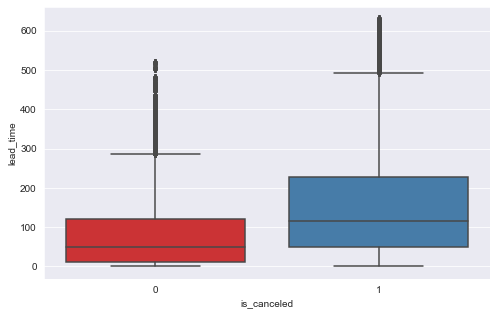

In [5]:
fig, axes = plt.subplots(figsize=(8,5))
sns.boxplot(y = 'lead_time', x = 'is_canceled', data = city, palette="Set1", ax = axes)

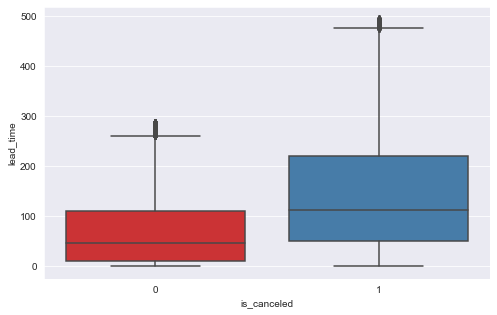

In [6]:
dum = city[city['is_canceled'] == 0].copy()
q1 = dum['lead_time'].quantile(0.25)
q3 = dum['lead_time'].quantile(0.75)
iqr = q3 - q1
low = q1 - 1.5 * iqr
high = q3 + 1.5 * iqr
drop_list = list(dum[((dum['lead_time'] > high) | (dum['lead_time'] < low))].index)

city.drop(drop_list, inplace = True)
city.reset_index(drop = True, inplace = True)

dum = city[city['is_canceled'] == 1].copy()
q1 = dum['lead_time'].quantile(0.25)
q3 = dum['lead_time'].quantile(0.75)
iqr = q3 - q1
low = q1 - 1.5 * iqr
high = q3 + 1.5 * iqr
drop_list = list(dum[((dum['lead_time'] > high) | (dum['lead_time'] < low))].index)

city.drop(drop_list, inplace = True)
city.reset_index(drop = True, inplace = True)

fig, axes = plt.subplots(figsize=(8,5))
sns.boxplot(y = 'lead_time', x = 'is_canceled', data = city, palette="Set1", ax = axes)

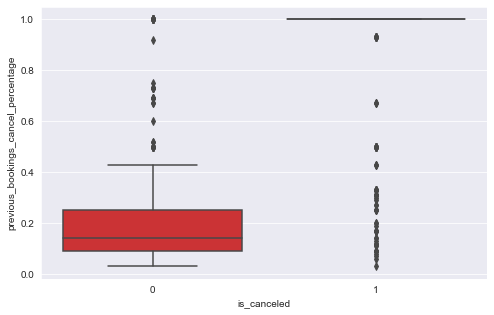

In [7]:
fig, axes = plt.subplots(figsize=(8,5))
sns.boxplot(y = 'previous_bookings_cancel_percentage', x = 'is_canceled', 
            data = city[city['previous_bookings_cancel_percentage'] != 0], 
            palette="Set1", ax = axes)

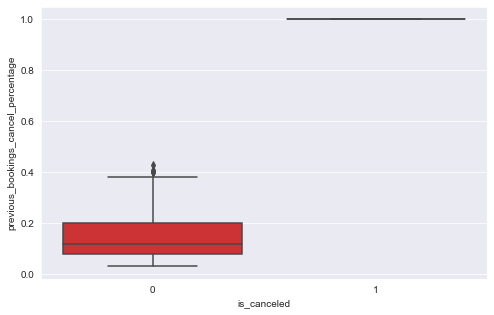

In [8]:
dum = city[(city['is_canceled'] == 0) & (city['previous_bookings_cancel_percentage'] != 0)].copy()
q1 = dum['previous_bookings_cancel_percentage'].quantile(0.25)
q3 = dum['previous_bookings_cancel_percentage'].quantile(0.75)
iqr = q3 - q1
low = q1 - 1.5 * iqr
high = q3 + 1.5 * iqr
drop_list = list(dum[(dum['previous_bookings_cancel_percentage'] > high) | 
                      (dum['previous_bookings_cancel_percentage'] < low)].index)

city.drop(drop_list, inplace = True)
city.reset_index(drop = True, inplace = True)

dum = city[(city['is_canceled'] == 1) & (city['previous_bookings_cancel_percentage'] != 0)].copy()
q1 = dum['previous_bookings_cancel_percentage'].quantile(0.25)
q3 = dum['previous_bookings_cancel_percentage'].quantile(0.75)
iqr = q3 - q1
low = q1 - 1.5 * iqr
high = q3 + 1.5 * iqr
drop_list = list(dum[(dum['previous_bookings_cancel_percentage'] > high) | 
                      (dum['previous_bookings_cancel_percentage'] < low)].index)

city.drop(drop_list, inplace = True)
city.reset_index(drop = True, inplace = True)

fig, axes = plt.subplots(figsize=(8,5))
sns.boxplot(y = 'previous_bookings_cancel_percentage', x = 'is_canceled', 
            data = city[city['previous_bookings_cancel_percentage'] != 0], 
            palette="Set1", ax = axes)

(0, 1000)

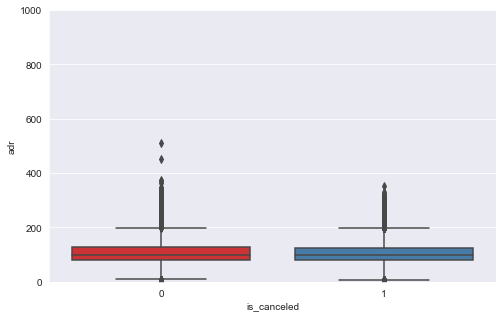

In [9]:
fig, axes = plt.subplots(figsize=(8,5))
sns.boxplot(y = 'adr', x = 'is_canceled', data = city, palette="Set1", ax = axes)
axes.set_ylim(0,1000)

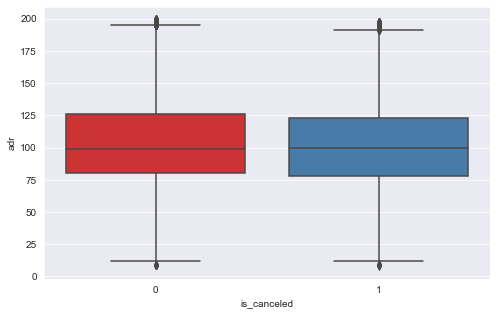

In [10]:
dum = city[city['is_canceled'] == 0].copy()
q1 = dum['adr'].quantile(0.25)
q3 = dum['adr'].quantile(0.75)
iqr = q3 - q1
low = q1 - 1.5 * iqr
high = q3 + 1.5 * iqr
drop_list = list(dum[((dum['adr'] > high) | (dum['adr'] < low))].index)

city.drop(drop_list, inplace = True)
city.reset_index(drop = True, inplace = True)

dum = city[city['is_canceled'] == 1].copy()
q1 = dum['adr'].quantile(0.25)
q3 = dum['adr'].quantile(0.75)
iqr = q3 - q1
low = q1 - 1.5 * iqr
high = q3 + 1.5 * iqr
drop_list = list(dum[((dum['adr'] > high) | (dum['adr'] < low))].index)

city.drop(drop_list, inplace = True)
city.reset_index(drop = True, inplace = True)

fig, axes = plt.subplots(figsize=(8,5))
sns.boxplot(y = 'adr', x = 'is_canceled', data = city, palette="Set1", ax = axes)

In [11]:
city.select_dtypes(include = 'object')

,arrival_date_month,meal,market_segment,distribution_channel,reserved_room_type,assigned_room_type,customer_type,arrival_date_week_of_month
0,July,BB,Online TA,TA/TO,A,A,Transient,1st week
1,July,BB,Online TA,TA/TO,A,A,Transient,1st week
2,July,BB,Online TA,TA/TO,A,A,Transient,1st week
3,July,BB,Online TA,TA/TO,A,A,Transient,1st week
4,July,BB,Online TA,TA/TO,A,A,Transient,1st week
...,...,...,...,...,...,...,...,...
73667,August,BB,Offline TA/TO,TA/TO,A,A,Transient,4th week
73668,August,BB,Offline TA/TO,TA/TO,A,A,Transient,4th week
73669,August,BB,Online TA,TA/TO,D,D,Transient,4th week
73670,August,BB,Online TA,TA/TO,A,A,Transient,4th week


In [12]:
cat_columns = city.select_dtypes(include = 'object').columns
dummies_df = pd.get_dummies(city[cat_columns], drop_first = True)
city.drop(cat_columns, axis = 1, inplace = True)
final = pd.concat([city, dummies_df], axis = 1)
final.head()

,is_canceled,lead_time,adults,is_repeated_guest,booking_changes,adr,required_car_parking_spaces,total_of_special_requests,days_of_stay,kids,...,assigned_room_type_E,assigned_room_type_F,assigned_room_type_G,assigned_room_type_K,customer_type_Group,customer_type_Transient,customer_type_Transient-Party,arrival_date_week_of_month_2nd week,arrival_date_week_of_month_3rd week,arrival_date_week_of_month_4th week
0,1,88,2,0,0,76.5,0,1,4,0,...,0,0,0,0,0,1,0,0,0,0
1,1,65,1,0,0,68.0,0,1,4,0,...,0,0,0,0,0,1,0,0,0,0
2,1,92,2,0,0,76.5,0,2,6,0,...,0,0,0,0,0,1,0,0,0,0
3,1,100,2,0,0,76.5,0,1,2,0,...,0,0,0,0,0,1,0,0,0,0
4,1,79,2,0,0,76.5,0,1,3,0,...,0,0,0,0,0,1,0,0,0,0


### Predictive Models

In [13]:
# Import necessary packages
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score

# Import metric
from sklearn.metrics import roc_auc_score

In [14]:
# Import models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb
import lightgbm as lgb

In [15]:
# Split into train and test set
X_train, X_test, y_train, y_test = train_test_split(final.drop('is_canceled', axis = 1), 
                                                    final['is_canceled'], shuffle = True,
                                                    random_state = 7)

# Define a function for evaluating the model, first a pipeline object is built, this is done
# because in cross validation we want the fitting of the standard scaling to be appled only 
# to the train and not the validation set to avoid possible data leakage. 
# Cross validaton with 3 different metrics is applied and the mean and standard deviation
# of each metric are computed.

def model_eval(X, y, model):
    
    pipe = Pipeline([('scaler', StandardScaler()), ('model', model)])
    cv = KFold(n_splits = 7, shuffle = True, random_state = 7)
    results = cross_validate(pipe, X, y, cv = cv, scoring = 'roc_auc', n_jobs = -1)
    
    score = {}
    score['value'] = np.mean(results['test_score'])
    score['std'] = np.std(results['test_score'])
    
    message = 'roc_auc: {} (+/- {}) \n'.format(score['value'], score['std'])
    
    evaluation = {'metric':score, 'evaluation results':message}
    return evaluation

In [16]:
%%time

lr_eval = model_eval(X_train, y_train, LogisticRegression())
print(lr_eval['evaluation results'])

roc_auc: 0.8594347492944218 (+/- 0.003564675895174741) 

Wall time: 3.49 s


In [17]:
%%time

nb_eval = model_eval(X_train, y_train, GaussianNB())
print(nb_eval['evaluation results'])

roc_auc: 0.8017191018331442 (+/- 0.006069313363944749) 

Wall time: 1.19 s


In [18]:
%%time

knn_eval = model_eval(X_train, y_train, KNeighborsClassifier())
print(knn_eval['evaluation results'])

roc_auc: 0.883219213830131 (+/- 0.004761556276632814) 

Wall time: 1min


In [19]:
%%time

rf_eval = model_eval(X_train, y_train, RandomForestClassifier(random_state = 8))
print(rf_eval['evaluation results'])

roc_auc: 0.9297376743586397 (+/- 0.0025905862358325854) 

Wall time: 10.7 s


In [20]:
%%time

svm_eval = model_eval(X_train, y_train, SVC())
print(svm_eval['evaluation results'])

roc_auc: 0.8879276733783328 (+/- 0.0031908882544880715) 

Wall time: 5min 17s


In [21]:
%%time

xgb_eval = model_eval(X_train, y_train, xgb.XGBClassifier(random_state = 8))
print(xgb_eval['evaluation results'])

roc_auc: 0.8826269533501007 (+/- 0.0036024206411482108) 

Wall time: 6.65 s


In [22]:
%%time

lgb_eval = model_eval(X_train, y_train, lgb.LGBMClassifier(random_state = 8))
print(lgb_eval['evaluation results'])

roc_auc: 0.9128642629458291 (+/- 0.003077283065879511) 

Wall time: 3.37 s


##### Tuning

In [23]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from skopt import BayesSearchCV

def grid_model_eval(X, y, model, params):
    
    pipe = Pipeline([('scaler', StandardScaler()), ('model', model)])
    grid = GridSearchCV(estimator = pipe, param_grid = params, 
                        scoring = 'roc_auc', n_jobs = -1,
                        cv = 7)
    grid.fit(X, y)
    return grid

def rand_model_eval(X, y, model, params, iters):
        
    pipe = Pipeline([('scaler', StandardScaler()), ('model', model)])
    grid = RandomizedSearchCV(estimator = pipe, param_distributions = params, 
                              n_iter = iters, 
                              scoring = 'roc_auc', n_jobs = -1,
                              cv = 7)
    grid.fit(X, y)
    return grid

def bayes_model_eval(X, y, model, params, iters):
        
    pipe = Pipeline([('scaler', StandardScaler()), ('model', model)])
    grid = BayesSearchCV(estimator = pipe, search_spaces = params, 
                              n_iter = iters, 
                              scoring = 'roc_auc', n_jobs = -1,
                              cv = 7)
    grid.fit(X, y)
    return grid

In [19]:
%%time

#KNN & Grid
params = {'model__n_neighbors': [3,5,7,9], 'model__weights': ['uniform', 'distance']}

model = KNeighborsClassifier()
knn_grid = grid_model_eval(X_train, y_train, model, params)
knn_grid.best_score_

Wall time: 7min 46s


0.9082225463839114

In [31]:
knn_ind = knn_grid.best_index_
print(knn_grid.cv_results_['mean_test_score'][knn_ind])
print(knn_grid.cv_results_['std_test_score'][knn_ind])
print(knn_grid.best_params_)

0.9082225463839114
0.0023068759994371137
{'model__n_neighbors': 9, 'model__weights': 'distance'}


In [20]:
%%time

# Random Forest & RandomGrid
params = {'model__n_estimators': list(range(100,1200,50)),
          'model__min_samples_split': list(range(2,12)),
          'model__max_depth': list(range(1, 40)), 
          'model__min_samples_leaf': list(range(1,15)),
          'model__max_features': list(np.arange(0.4,0.95,0.05)),
          'model__max_samples': list(np.arange(0.4,0.95,0.05)),
          'model__random_state': [8]}

model = RandomForestClassifier()
rfr_rgrid = rand_model_eval(X_train, y_train, model, params, 30)
rfr_rgrid.best_score_

Wall time: 34min 34s


0.9299223743669724

In [37]:
rfr_rgrid.best_estimator_

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('model',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=26,
                                        max_features=0.6499999999999999,
                                        max_leaf_nodes=None,
                                        max_samples=0.7999999999999999,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=2, min_samples_split=4,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=350, n_jobs=None,
                                        oob_score=False, random_state=8,
              

In [28]:
rfr_ind = rfr_rgrid.best_index_
print(rfr_rgrid.cv_results_['mean_test_score'][rfr_ind])
print(rfr_rgrid.cv_results_['std_test_score'][rfr_ind])
print(rfr_rgrid.best_params_)

0.9299223743669724
0.002472785987764914
{'model__random_state': 8, 'model__n_estimators': 350, 'model__min_samples_split': 4, 'model__min_samples_leaf': 2, 'model__max_samples': 0.7999999999999999, 'model__max_features': 0.6499999999999999, 'model__max_depth': 26}


In [21]:
%%time

# XGBoost & RandomGrid
params = {'model__learning_rate': list(np.logspace(np.log(0.001), np.log(0.5), num = 30, base=2)),
          'model__min_split_loss': list(range(0,8)),
          'model__max_depth': list(range(1, 40)), 
          'model__min_child_weight': list(range(1,15)),
          'model__subsample': list(np.arange(0.4,0.95,0.05)),
          'model__colsample_bytree': list(np.arange(0.4,0.95,0.05)),
          'model__n_estimators': list(range(100,1200,50)),
          'model__seed': [8]}

model = xgb.XGBClassifier()
xgb_rgrid = rand_model_eval(X_train, y_train, model, params, 30)
xgb_rgrid.best_score_

Wall time: 1h 20min 17s


0.929378169647001

In [38]:
xgb_rgrid.best_estimator_

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('model',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.7, gamma=0,
                               learning_rate=0.042674257497373136,
                               max_delta_step=0, max_depth=30,
                               min_child_weight=2, min_split_loss=5,
                               missing=None, n_estimators=1000, n_jobs=1,
                               nthread=None, objective='binary:logistic',
                               random_state=0, reg_alpha=0, reg_lambda=1,
                               scale_pos_weight=1, seed=8, silent=None,
                               subsample=0.7, verbosity=1))],
         verbose=False)

In [32]:
xgb_ind = xgb_rgrid.best_index_
print(xgb_rgrid.cv_results_['mean_test_score'][xgb_ind])
print(xgb_rgrid.cv_results_['std_test_score'][xgb_ind])
print(xgb_rgrid.best_params_)

0.929378169647001
0.002688454649940205
{'model__subsample': 0.7, 'model__seed': 8, 'model__n_estimators': 1000, 'model__min_split_loss': 5, 'model__min_child_weight': 2, 'model__max_depth': 30, 'model__learning_rate': 0.042674257497373136, 'model__colsample_bytree': 0.7}


In [42]:
%%time

# Light GB & Bayes Grid
params = {'model__bagging_fraction': list(np.arange(0.4,0.95,0.05)),
          'model__bagging_freq': list(range(0,40, 5)),
          'model__feature_fraction': list(np.arange(0.4,0.95,0.05)),
          'model__max_depth': list(range(-1,30,2)),
          'model__max_bin': list(range(200,300,5)),
          'model__num_iterations': list(range(50,400,50)),
          'model__learning_rate': list(np.logspace(np.log(0.001), np.log(0.5), num = 15, base=2)),
          'model__min_data_in_leaf': list(range(10,50,2)),
          'model__random_state': [5]}

model = lgb.LGBMClassifier()
lgb_bgrid = bayes_model_eval(X_train, y_train, model, params, 40)
lgb_bgrid.best_score_

Wall time: 3min 45s

0.9244001692849823


In [39]:
lgb_bgrid.best_estimator_

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('model',
                 LGBMClassifier(bagging_fraction=0.8499999999999999,
                                bagging_freq=25, boosting_type='gbdt',
                                class_weight=None, colsample_bytree=1.0,
                                feature_fraction=0.55, importance_type='split',
                                learning_rate=0.24573088208517854, max_bin=205,
                                max_depth=27, min_child_samples=20,
                                min_child_weight=0.001, min_data_in_leaf=40,
                                min_split_gain=0.0, n_estimators=100, n_jobs=-1,
                                num_iterations=350, num_leaves=31,
                                objective=None, random_state=5, reg_alpha=0.0,
                                reg_lambda=0.0, silent=True, subsample=1.0,
                            

In [33]:
lgb_ind = lgb_bgrid.best_index_
print(lgb_bgrid.cv_results_['mean_test_score'][lgb_ind])
print(lgb_bgrid.cv_results_['std_test_score'][lgb_ind])
print(lgb_bgrid.best_params_)

0.9244001692849823
0.002953245349885798
OrderedDict([('model__bagging_fraction', 0.8499999999999999), ('model__bagging_freq', 25), ('model__feature_fraction', 0.55), ('model__learning_rate', 0.24573088208517854), ('model__max_bin', 205), ('model__max_depth', 27), ('model__min_data_in_leaf', 40), ('model__num_iterations', 350), ('model__random_state', 5)])


#### Models Comparison

In [66]:
model_eval = [lr_eval, nb_eval, knn_eval, rf_eval, svm_eval, xgb_eval, lgb_eval]
models_res = pd.DataFrame({'models':['Logistic Regression', 'Naive Bayes', 'KNN', 'Random Forest', 'SVM', 'XGB', 'LGBM'],
                           'roc_auc':[evaluation['metric']['value'] for evaluation in model_eval],
                           'std':[evaluation['metric']['std'] for evaluation in model_eval]})
models_res['tuning'] = 'no'


model_eval_new = [knn_grid, rfr_rgrid, xgb_rgrid, lgb_bgrid]
models_res_new = pd.DataFrame({'models':['KNN', 'Random Forest', 'XGB', 'LGBM'],
                           'roc_auc':[tuned.cv_results_['mean_test_score'][tuned.best_index_] for tuned in model_eval_new],
                           'std':[tuned.cv_results_['std_test_score'][tuned.best_index_] for tuned in model_eval_new]})
models_res_new['tuning'] = 'yes'
all_models = pd.concat([models_res, models_res_new])

Text(0.5, 1.0, 'Models performance')

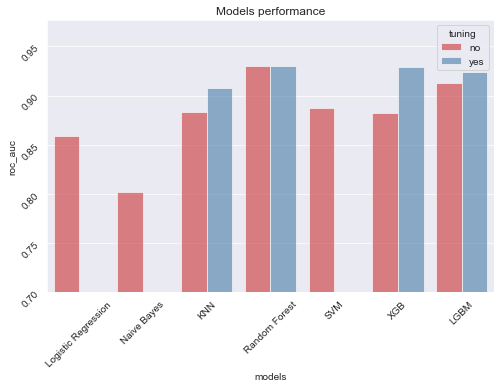

In [64]:
fig, axes = plt.subplots(figsize=(8,5))
sns.barplot(y = 'roc_auc', x = 'models', data = all_models, palette="Set1", 
            ax = axes, alpha = 0.6, hue = 'tuning')
axes.tick_params(labelrotation=45)
axes.set_ylim(bottom = 0.7)
axes.set_title('Models performance')